In [4]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import math, time
import itertools
from sklearn import preprocessing
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import SimpleRNN
style.use('ggplot')

/home/diptiranjan/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
Using TensorFlow backend.


# Get company's stock data

Fill in the ticker of the company (in place of stock_dfs/%s) on which prediction is needed to be done.
stock_dfs/ contains all the ticker data starting from intial date till end.

In [5]:

df = pd.read_csv('stock_dfs/ADBE.csv', parse_dates=True, index_col=0)
# print values from start date i.e. 2000-1-1 -> Date, Open, High ,Low, Close, Volume, Adj Close
print(df.head())


               Open     High      Low    Close    Volume  Adj Close
Date                                                               
2000-01-03  67.2500  67.5000  64.2500  65.5625   7384400  16.274673
2000-01-04  63.0000  65.8125  59.9375  60.0625   7813200  14.909400
2000-01-05  58.2500  62.7500  58.2500  61.2500  14927200  15.204175
2000-01-06  61.4375  62.6250  60.6250  61.7500  10221200  15.328291
2000-01-07  61.5625  64.7500  60.8750  64.7500   8253200  16.072985


# Plot company's Closing Prices and Volume sold over the years

Populating the interactive namespace from numpy and matplotlib


/home/diptiranjan/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


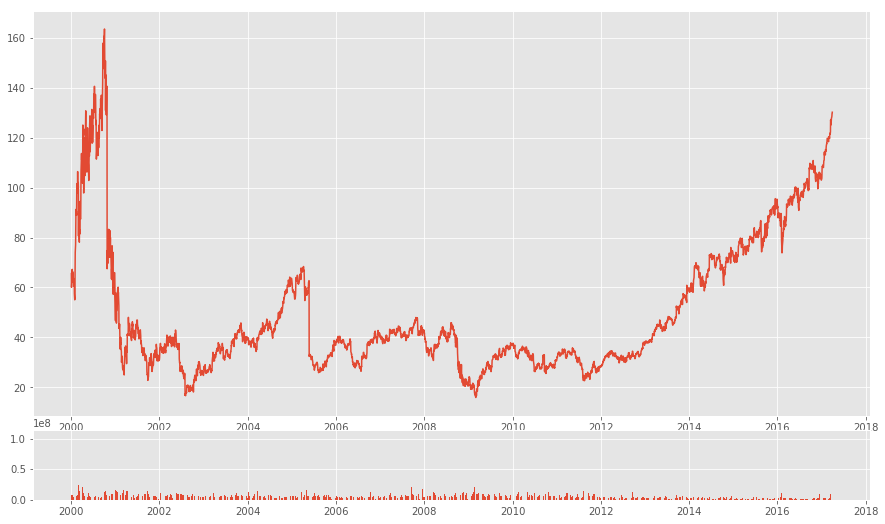

In [3]:
# Control the default size of figures in this Jupyter notebook
%pylab inline

pylab.rcParams['figure.figsize'] = (15, 9)
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1)
#ax1.plot(df.index, df['Adj Close'])
ax1.plot(df.index, df['Close'])
ax2.bar(df.index, df['Volume'])
plt.show()

Print all values contained in dataframe

-Open is the price of the stock at the beginning of the trading day (it need not be the closing price of the previous trading day),

-high is the highest price of the stock on that trading day,

-low the lowest price of the stock on that trading day, and

-close the price of the stock at closing time.

-Volume indicates how many stocks were traded.

-Adjusted close is the closing price of the stock that adjusts the price of the stock for corporate actions. While stock prices are considered to be set mostly by traders, stock splits (when the company makes each extant stock worth two and halves the price) and dividends (payout of company profits per share) also affect the price of a stock and should be accounted for.


In [4]:
print(df)

                  Open        High         Low       Close    Volume  \
Date                                                                   
2000-01-03   67.250000   67.500000   64.250000   65.562500   7384400   
2000-01-04   63.000000   65.812500   59.937500   60.062500   7813200   
2000-01-05   58.250000   62.750000   58.250000   61.250000  14927200   
2000-01-06   61.437500   62.625000   60.625000   61.750000  10221200   
2000-01-07   61.562500   64.750000   60.875000   64.750000   8253200   
2000-01-10   65.375000   67.250000   63.625000   67.250000  10987200   
2000-01-11   67.187500   67.250000   62.375000   62.625000   9616000   
2000-01-12   62.750000   63.375000   61.750000   62.312500   8051200   
2000-01-13   62.812500   66.000000   62.750000   65.625000   5527200   
2000-01-14   66.625000   67.375000   65.625000   66.312500   5136800   
2000-01-18   65.062500   65.875000   64.000000   64.000000   5201600   
2000-01-19   63.718700   64.375000   62.500000   63.125000   455

Know the shape of data

In [6]:
data = df[:]
data
data.shape

(4339, 6)

# Visualize Feature Distributions

To get a better understanding of the dataset, we can construct a scatter matrix of each of the six stock features present in the data. 

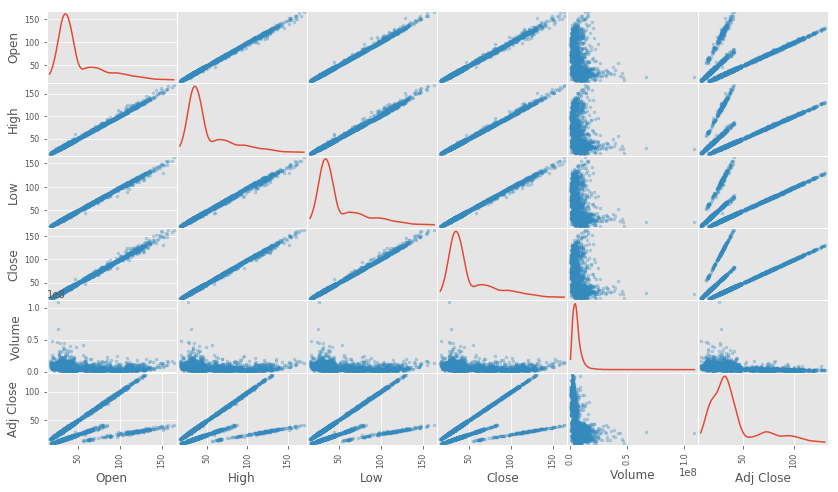

In [8]:
from IPython.display import display

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');



# Split data into Training and Testing set

In [9]:

def train_test_split(data,SEQ_LENGTH = 25,test_prop=0.3):
    data = data.sort_index()
    
    ntrain = int(len(data) *(1-test_prop))
    predictors = data.columns[:4]
    #norms = data[predictors].apply(np.linalg.norm)
    data_pred = data[predictors] #/norms
    num_attr = data_pred.shape[1]
    result = np.empty((len(data) - SEQ_LENGTH - 1, SEQ_LENGTH, num_attr))
    y = np.empty(len(data) - SEQ_LENGTH - 1)
    yopen = np.empty(len(data) - SEQ_LENGTH - 1)

    for index in range(len(data) - SEQ_LENGTH - 1):
        result[index, :, :] = data_pred[index: index + SEQ_LENGTH]
        y[index] = data.iloc[index + SEQ_LENGTH + 1].Close
        yopen[index] = data.iloc[index + SEQ_LENGTH + 1].Open

    xtrain = result[:ntrain, :, :]
    ytrain = y[:ntrain]
    xtest = result[ntrain:, :, :]
    ytest = y[ntrain:]
    ytest_open = yopen[ntrain:]
    return xtrain, xtest, ytrain, ytest, ytest_open

# Training the model

In [10]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing import sequence

Define the model 

In [11]:
def train_model(xtrain,ytrain,SEQ_LENGTH=25,N_HIDDEN=256):
    # SEQ_LENGTH = 25  # Sequence Length, or # of days of trading
    # N_HIDDEN = 256  # Number of units in the hidden (LSTM) layers
    # num_attr = 4  # Number of predictors used for each trading day
    num_attr = xtrain.shape[2]
    model = Sequential()
    model.add(LSTM(N_HIDDEN, return_sequences=True, activation='tanh', input_shape=(SEQ_LENGTH, num_attr)))
    model.add(Dropout(0.2))
    model.add(LSTM(N_HIDDEN, return_sequences=False, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(loss="mean_squared_error", optimizer='adam')  ## optimizer = 'rmsprop'
    model.fit(xtrain, ytrain, batch_size=50, nb_epoch=20, validation_split=0.05)
    return model
  
    #Can add CNN here, but results are not promising always
    #model.add(Conv1D(filters=25, kernel_size=3, padding='same', activation='relu'))
                                                                                       

Define prediction function

In [12]:
def predict(model,xtest):
    predicted = model.predict(xtest)
    return predicted

Time to split the data, Call Train_test_split

In [13]:
xtrain, xtest, ytrain, ytest, ytest_open = train_test_split(data)
print('xtrain.shape',xtrain.shape, 'xtest.shape',xtest.shape)
print('ytrain.shape',ytrain.shape, 'ytest.shape',ytest.shape)

xtrain.shape (3037, 25, 4) xtest.shape (1276, 25, 4)
ytrain.shape (3037,) ytest.shape (1276,)


Train the model 

In [14]:
model = train_model(xtrain,ytrain)

/home/diptiranjan/anaconda3/lib/python3.6/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 2885 samples, validate on 152 samples
Epoch 1/20
2885/2885 [==============================] - 24s - loss: 1217.1672 - val_loss: 7.5803

# Save and Load the Trained model

In [21]:
#Load trained model
f_name = "lstm_200_ADBE"
model.load_weights(f_name)

In [15]:
#save trained model...

f_name = "lstm_20_ADBE"
model.save_weights(f_name, overwrite = True)

# Prediction and Plotting

Plot closing prices

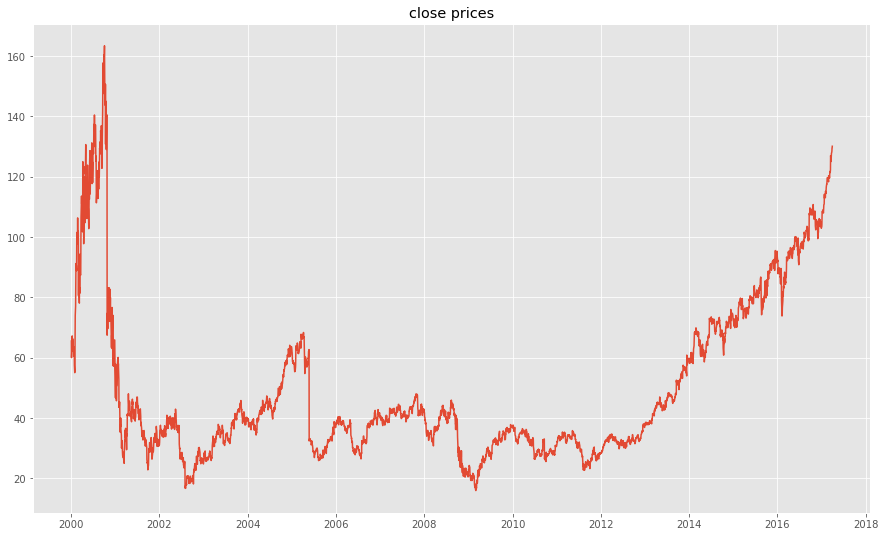

In [17]:
pylab.rcParams['figure.figsize'] = (15, 9)
plt.plot(data.Close)
plt.title('close prices')
plt.show()

Plot CandleStick graph

In [28]:
#Resample the data to 10 day data.
df_ohlc = df['Adj Close'].resample('10D').ohlc()
df_volume = df['Volume'].resample('10D').sum()
print(df_ohlc.head())


                 open       high        low      close
Date                                                  
2000-01-03  16.274673  16.693563  14.909400  15.467921
2000-01-13  16.290187  16.460846  15.607551  15.607551
2000-01-23  15.033516  15.638580  13.668243  13.869931
2000-02-02  15.219689  22.651118  15.219689  22.449430
2000-02-12  22.247742  25.211004  22.061568  24.388738


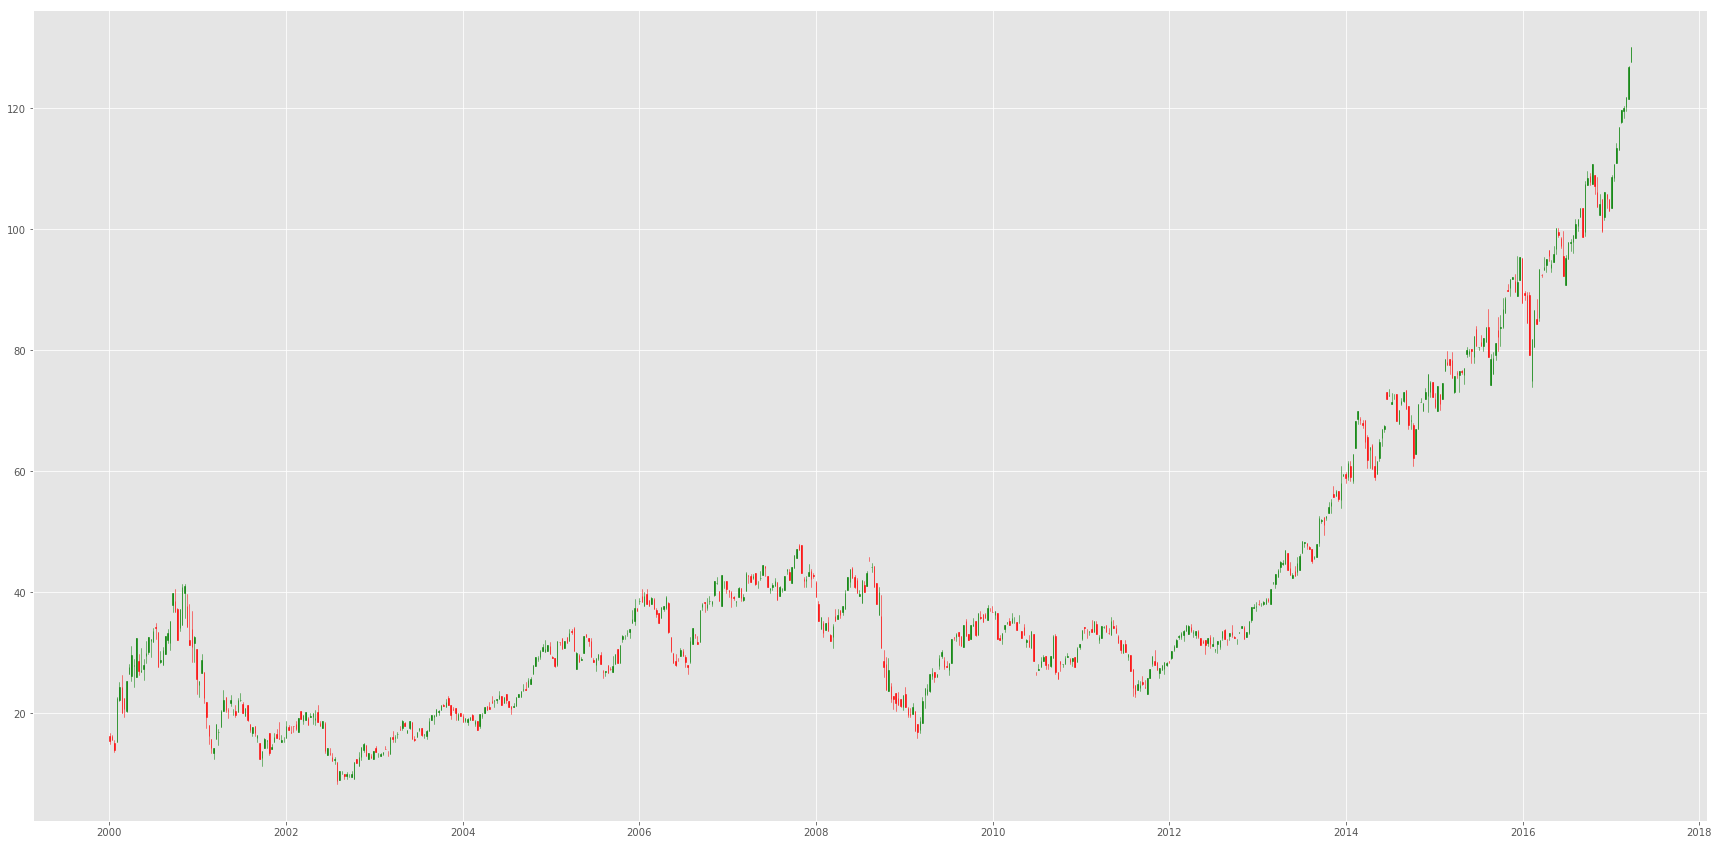

In [29]:
#CandleStick graph

pylab.rcParams['figure.figsize'] = (30, 18)
df_ohlc.reset_index(inplace = True)
df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
#ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex = ax1)
ax1.xaxis_date()

candlestick_ohlc(ax1, df_ohlc.values, width=2, colorup='g')
#ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values, 0)

plt.show()

Time to plot the TRAINING SET -> Predicted_closing prices & Closing prices

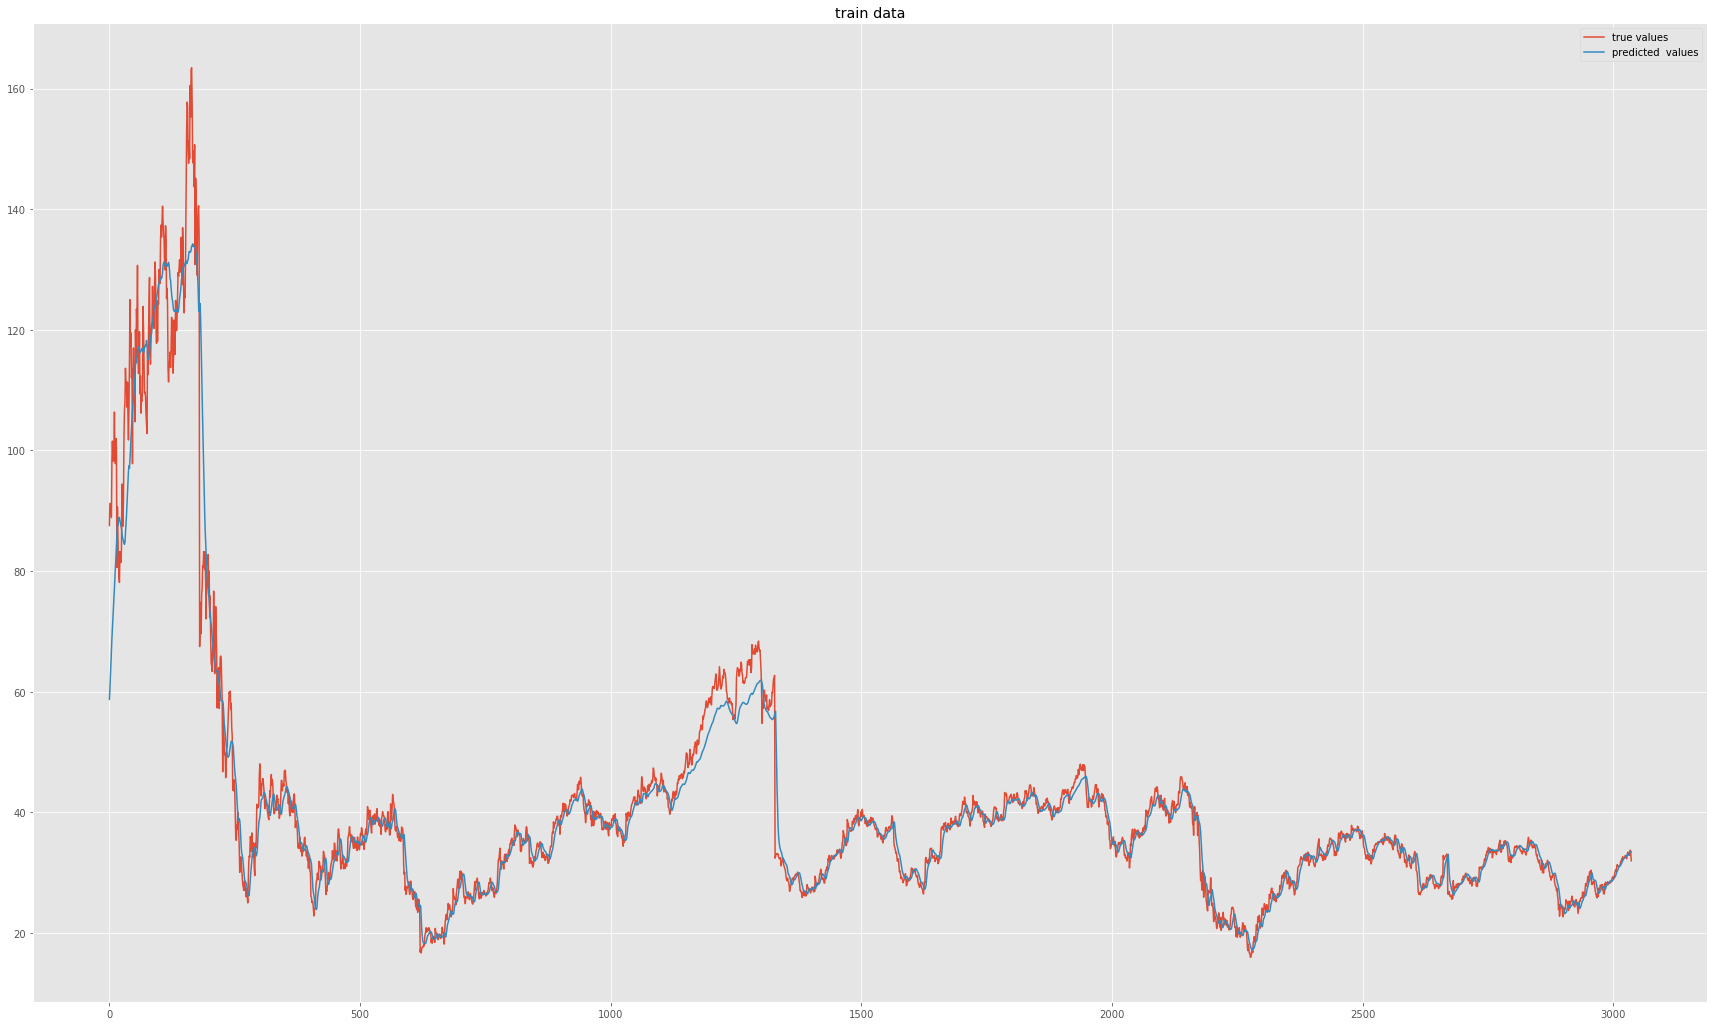

In [30]:
predicted_tr = model.predict(xtrain)
plt.plot(ytrain, label='true values')
plt.plot(predicted_tr, label='predicted  values')
plt.legend()
plt.title('train data')
plt.show()

Now, TEST SET

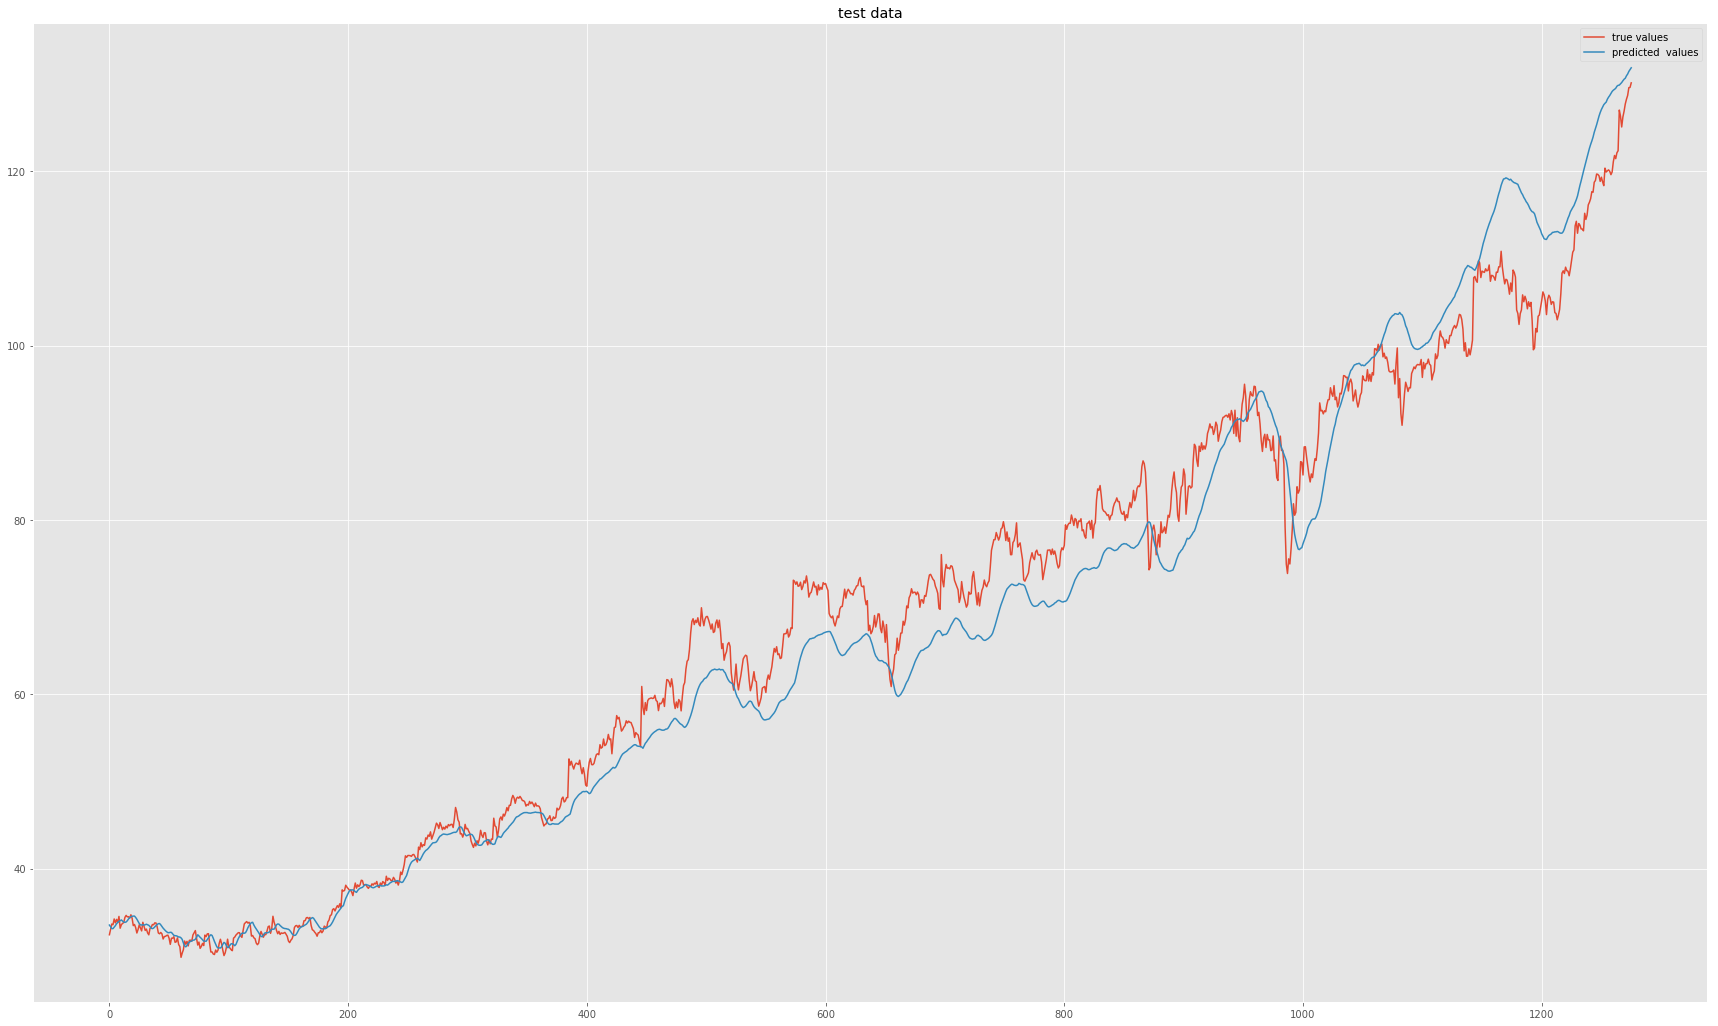

In [31]:
predicted_test = model.predict(xtest)
plt.plot(ytest, label='true values')
plt.plot(predicted_test, label='predicted  values')
plt.legend()
plt.title('test data')
plt.show()

Score

In [32]:
trainScore = math.sqrt(mean_squared_error(ytrain, predicted_tr[:,0]))
trainScore

4.389367272518275

In [33]:
testScore = math.sqrt(mean_squared_error(ytest, predicted_test[:,0]))
testScore

4.987638947759067

In [34]:
x_predict = model.predict(xtest)
x_predict[:,0]
predicted_test[:,0]

array([  33.51947021,   33.32668304,   33.11837769, ...,  131.4425354 ,
        131.65635681,  131.85868835], dtype=float32)

In [35]:
scores = model.evaluate(xtest, ytest, verbose=1)
print(scores)

1276/1276 [==============================] - 3s     

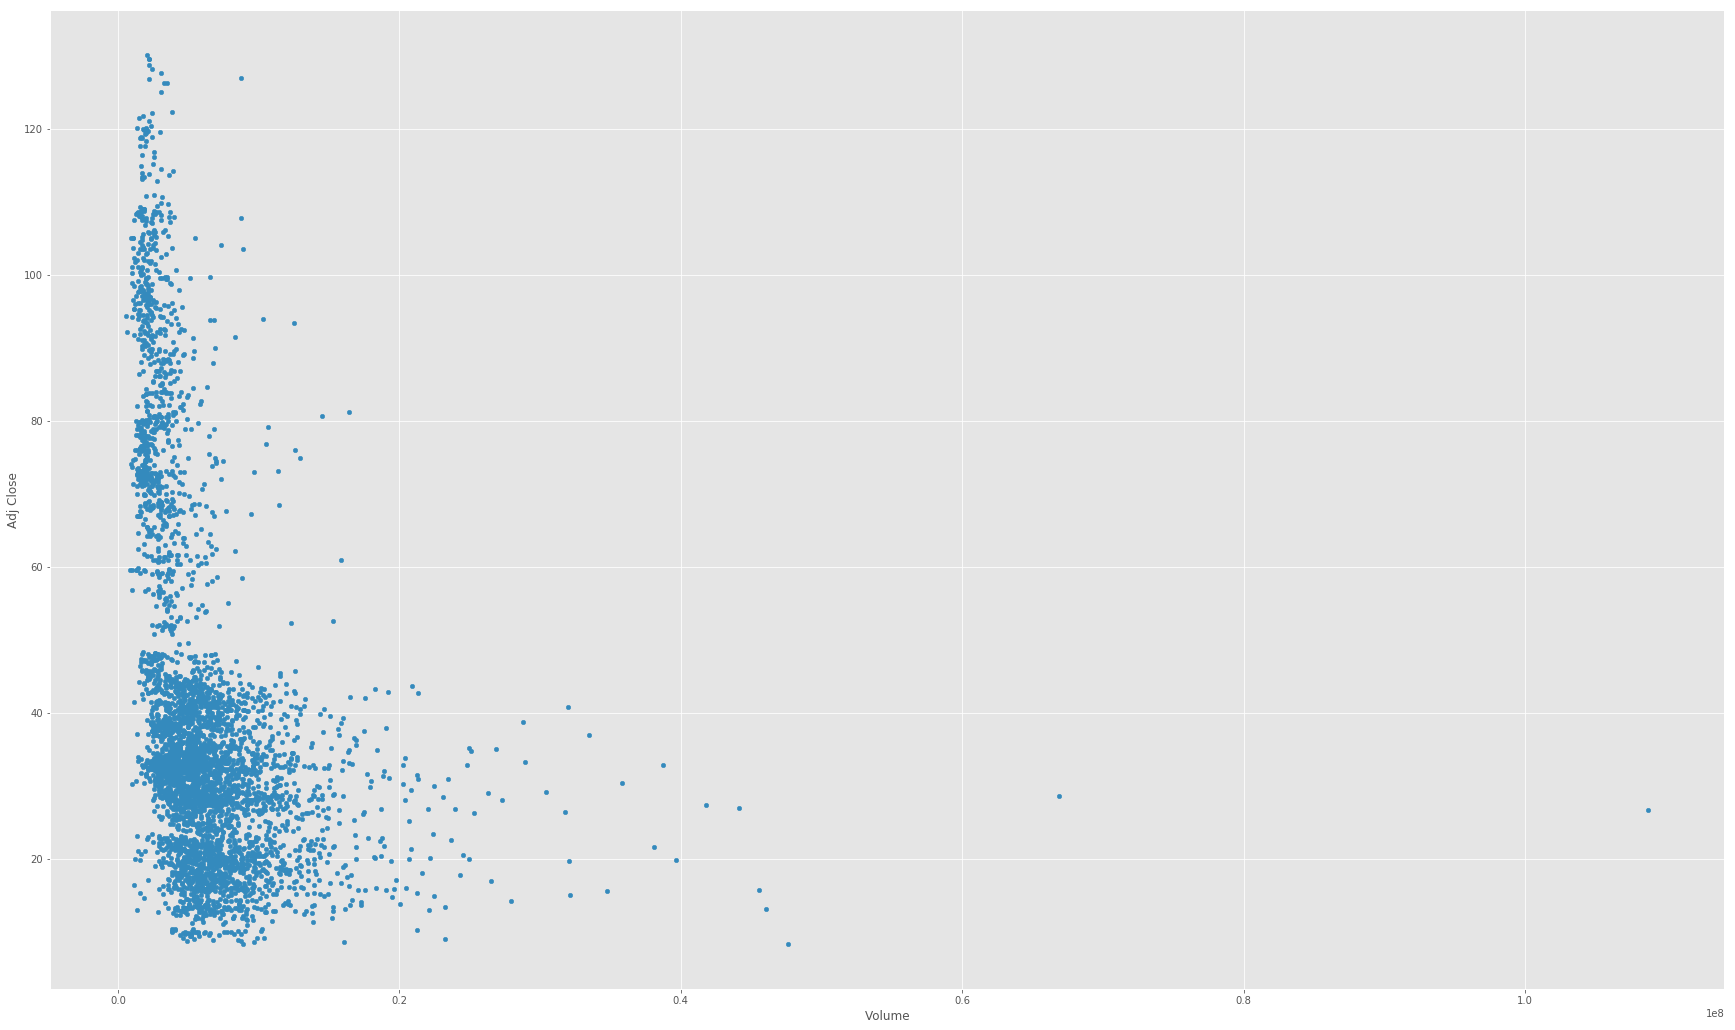

In [36]:
data.plot.scatter(x='Volume', y='Adj Close')

plt.show()

In [37]:
model.get_config()

[{'class_name': 'LSTM',
  'config': {'activation': 'tanh',
   'activity_regularizer': None,
   'batch_input_shape': (None, 25, 4),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'dropout': 0.0,
   'dtype': 'float32',
   'go_backwards': False,
   'implementation': 0,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'name': 'lstm_1',
   'recurrent_activation': 'hard_sigmoid',
   'recurrent_constraint': None,
   'recurrent_dropout': 0.0,
   'recurrent_initializer': {'class_name': 'Orthogonal',
    'config': {'gain': 1.0, 'seed': None}},
   'recurrent_regularizer': None,
   'return_sequences': True,
   'stateful': False,
   'trainable': True,
   'unit_forget_bias': True,
   'units': 256,
   'unroll': False,
   'use_bias': True}},
 {'class_

In [145]:
num_attr = xtrain.shape[2]
xtrain[1].shape

(25, 4)

# ----------------------------------END-----------------------------------